<a href="https://colab.research.google.com/github/FatimeNazliAs/Image-Segmentation-with-Oxford-IIIT-Pet-Dataset/blob/main/oxford_image_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**U-NET Modeli Nedir?**

2015 yılında Almanya, Freiburg Üniversitesi'nde Biyomedikal Görüntü Segmentasyonu için geliştirilmiştir. Günümüzde herhangi bir anlamsal bölümleme görevinde en popüler olarak kullanılan yaklaşımlardan biridir. Daha az eğitim örneğinden öğrenmek için tasarlanmış tamamen evrişimli bir sinir ağıdır. Bu, Jonathan Long ve diğerleri tarafından geliştirilen mevcut FCN - “Anlamsal segmentasyon için tamamen evrişimli ağlar” üzerinde bir gelişmedir. (2014).

Aşağıda U-Net modelinin nasıl işlediğine dair örnek verilmiştir.

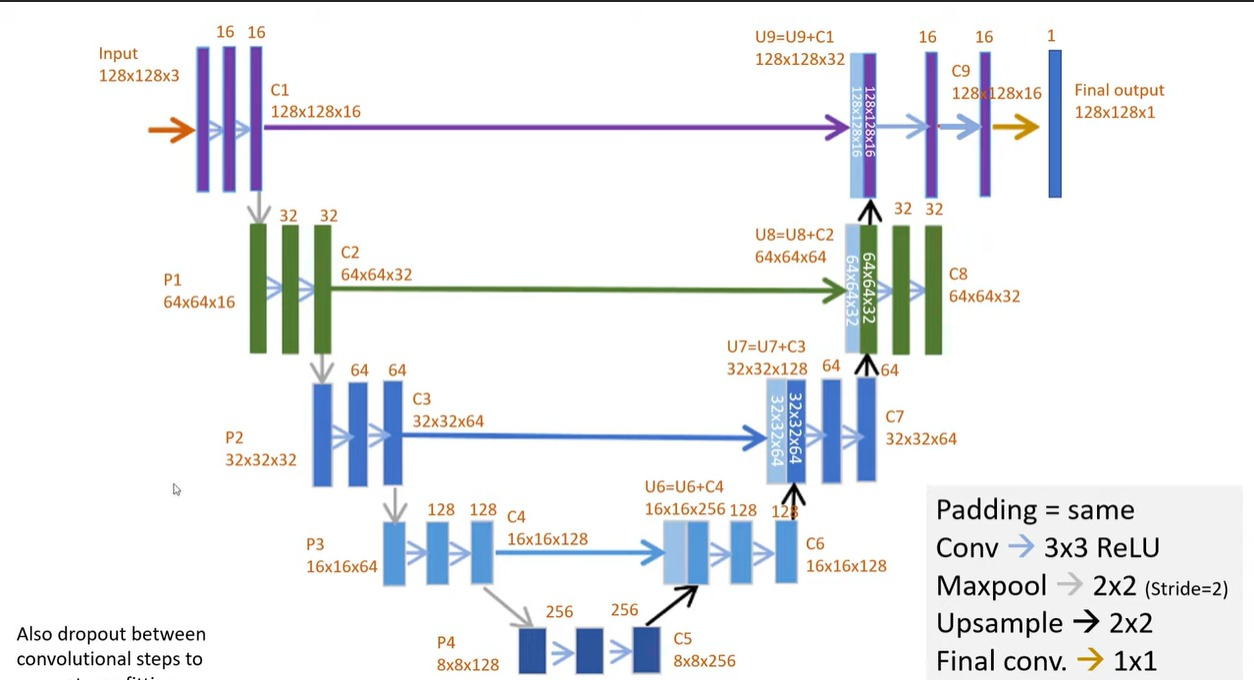

Fotoğrafların giriş boyutları: 128x128x3.

# **Encode:**
1)Convolution katmanı ile 16 tane özellik uygulandıktan sonra boyut 128x128x16 olur.

2)Maxpooling katmanı ile 2x2 matrix kullanılarak fotoğraflardaki en büyük 
piksel değerini alınır.Fotoğrafların boyutu 64x64x16'ya dönüşür.

3)Convolution katmanı ile 32 özellik uygulanır ve fotoğrafların boyutu 64x64x32'ye dönüşür.

Bu işlemler iki kez daha devam ettikten sonra 8x8x256 boyutlu fotoğraflar elde edilir.

# **Bottleneck:**
1)8x8x128 boyutuna sahip fotoğraflara iki kez Convolution katmanı uygulandıktan sonra 8x8x256'ya dönüşür. 
Elips yapıya benzeyen bu kısıma "*Darboğaz*" denir.

# **Decode:**
1)8x8x256 boyutlu fotoğraflar 2x2 matrix'ler kullanılarak boyutu 16x16x256'ya dönüştürülür.
Bu işleme "Upsampling" denir.

2)Bu katman ile 16X16X128 olan C4 katmanı birleştirilir. 
Bu işleme "*Concatenate*" denir.(u6=u6+u4)

3)Oluşan fotoğraflara 2 kez Convolution katmanı 128 özellik kullanılarak uygulanır ve 16x16x128 boyutlara sahip C6 oluşur. 

Bu işlemler iki kez daha devam ettikten sonra 128x128x32 boyutlu fotoğraflar elde edilir.

Convolution katmanı 16 özellik kullanılarak iki kez daha uygulandıktan sonra "*Final Output*" katmanı olan 128x128x1 olan fotoğraflar oluşur.
# Not:
Padding="same" : Giriş ve çıkış fotoğraflarının aynı boyutta 
olmasını sağlar.






*Youtube oynatma listesinden faydalanılmıştır:*
https://www.youtube.com/watch?v=azM57JuQpQI&list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE&index=1

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
#dataset-> Verinin kendisidir.
# info-> Veri ile ilgili bilgileri içerir.
dataset,info=tfds.load('oxford_iiit_pet:3.*.*',with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete77P23W/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete77P23W/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:

# input_image-> Veri kümesinden alınan bir resimdir.
# input_mask-> Veri kümesinden alınan ve daha önce eğitilmiş olan hazır maskedir.
# (128,128)-> resimlerin genişliği ve yüksekliğidir.
def resize(input_image,input_mask):
  input_image=tf.image.resize(input_image,(128,128),method="nearest")
  input_mask=tf.image.resize(input_mask,(128,128),method="nearest")
  return input_image,input_mask


def augment(input_image,input_mask):
  if tf.random.uniform(())>0.5:
     input_image=tf.image.flip_left_right(input_image)
     input_mask=tf.image.flip_left_right(input_mask)
  return input_image,input_mask


def normalize(input_image,input_mask):
  input_image=tf.cast(input_image,tf.float32)/255.0
  input_mask-=1
  return input_image,input_mask

def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask
def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

# train_dataset-> Train veri setinin load_image_train fonksiyonu ile çeşitli işlemler yapıldıktan sonra yüklenmesidir, eğitilecek  veridir.
# test_dataset-> Test veri setinin load_image_test fonksiyonu ile çeşitli işlemler yapıldıktan sonra yüklenmesidir, test edilecek  veridir.
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# BATCH_SIZE-> Bir yinelemede kullanılan eğitim örneklerinin sayısıdır.
# 3680 eğitim örneği ve 3669 test örneği vardır ve bunlar validation/test setlerine bölünmüştür. 
# U-Net modelini eğitmek için train_batches ve validation_batches kullanılır. 
# Eğitim bittikten sonra, model tahminlerini test etmek için test_batches kullanılır.

BATCH_SIZE=64
BUFFER_SIZE=1000
train_batches=train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches=train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches=test_dataset.take(3000).batch(BATCH_SIZE)
test_batches=test_dataset.skip(3000).take(669).batch(BATCH_SIZE)


In [ ]:
def display(display_list):
  plt.figure(figsize=(15,15))
  title=["Input Image","True Mask","Predicted Mask"]
  for i in range(len(display_list)):
    plt.subplot(1,len(display_list),i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

# n_filters-> filtre sayısı
# kernel_initalizer->Çekirdek ağırlıkları matrisi için başlatıcıdır.
# padding-> girdi ve çıktı resmin aynı boyutta olmasını sağlar.
# activation-> ağırlıklı toplamı hesaplayarak ve buna yanlılık ekleyerek bir nöronun etkinleştirilip etkinleştirilmemesi gerektiğine karar verir.
def double_conv_block(x,n_filters):
  x=layers.Conv2D(n_filters,3,padding="same",activation="relu",kernel_initializer="he_normal")(x)
  x=layers.Conv2D(n_filters,3,padding="same",activation="relu",kernel_initializer="he_normal")(x)
  
  return x
  
def downsample_block(x,n_filters):
   
    f=double_conv_block(x,n_filters)
    p=layers.MaxPool2D(2)(f)
    p=layers.Dropout(0.3)(p)
    return f,p


def upsample_block(x,conv_features,n_filters):
  x=layers.Conv2DTranspose(n_filters,3,2,padding="same")(x)
  x=layers.concatenate([x,conv_features])
  x=layers.Dropout(0.3)(x)
  x=double_conv_block(x,n_filters)
  return x






In [ ]:
  
  # f1,f2,f3,f4-> Convolution katmanı uygulanmıştır.
  # p1,p2,p3,p4-> MaxPool2D fonksiyonu ile resmin boyutları ikiye bölünmüştür.
def build_unet_model():
  inputs=layers.Input(shape=(128,128,3))
  # encoder:downsample
  f1,p1=downsample_block(inputs,64)
  f2,p2=downsample_block(p1,128)
  f3,p3=downsample_block(p2,256)
  f4,p4=downsample_block(p3,512)

  
  # bottleneck-> Katmanlarda encode işlemi bittikten ve decode işlemi başlamadan önce oluşan dar boğazdır.
  bottleneck=double_conv_block(p4,1024)
  # u6,u7,u8,u9-> Decode edilen katmanlardır. Bu katmanlara bir önceki decode edilmiş katman ve o sırada denk olan ve daha önceden encode edilmiş (f1,f2,f3,f4) 
  # olan katmanlar gönderilerek iki kısmın birleştirilmesi ve sonraki katmanı oluşturması sağlanır.
  # decoder: upsample
  u6=upsample_block(bottleneck,f4,512)
  u7=upsample_block(u6,f3,256)
  u8=upsample_block(u7,f2,128)
  u9=upsample_block(u8,f1,64)

# 3->Filtre sayısı
# 1-> Convolution katmanının yüksekliği ve genişliği
# outputs-> Encode ve decode edildikten sonra oluşan katmandır.
  outputs=layers.Conv2D(3,1,padding="same",activation = "softmax")(u9)

  unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
  return unet_model

#checkpoint -> Model ağırlıklarının kaydedileceği dizindir.
checkpoint_path = "drive/MyDrive/training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#cp_callback-> Her 5 epoch'da 1 modelin ağırlıklarını kaydeder.
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*BATCH_SIZE)

unet_model = build_unet_model()

unet_model.save_weights(checkpoint_path.format(epoch=0))



unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

# NUM_EPOCHS-> Öğrenme algoritmasının tüm eğitim veri kümesi boyunca çalışacağı sayıyı tanımlayan bir hiperparametredir.
# TRAIN_LENGTH-> Eğitilmesi gereken veri kümesinin uzunluğudur.
# STEPS_PER_EPOCH-> Her bir epoch'un kaç kere veriyi işleyeceğini gösterir.
# TEST_LENGTH-> Test edilmesi gereken veri kümesinin uzunluğudur.
NUM_EPOCHS = 20
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENGTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              callbacks=[cp_callback],
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/20
57/57 [==============================] - 132s 2s/step - loss: 0.9223 - accuracy: 0.5815 - val_loss: 0.8331 - val_accuracy: 0.6054
Epoch 2/20
57/57 [==============================] - 129s 2s/step - loss: 0.7797 - accuracy: 0.6420 - val_loss: 0.6843 - val_accuracy: 0.7244
Epoch 3/20
57/57 [==============================] - 119s 2s/step - loss: 0.6488 - accuracy: 0.7363 - val_loss: 0.6290 - val_accuracy: 0.7413
Epoch 4/20
57/57 [==============================] - 120s 2s/step - loss: 0.5808 - accuracy: 0.7689 - val_loss: 0.5408 - val_accuracy: 0.7882
Epoch 5/20
57/57 [==============================] - 120s 2s/step - loss: 0.5350 - accuracy: 0.7901 - val_loss: 0.4803 - val_accuracy: 0.8131
Epoch 6/20
34/57 [================>.............] - ETA: 40s - loss: 0.5014 - accuracy: 0.8048
Epoch 6: saving model to drive/MyDrive/training_2/cp-0006.ckpt
57/57 [==============================] - 121s 2s/step - loss: 0.4928 - accuracy: 0.8082 - val_loss: 0.4411 - val_accuracy: 0.8295
Epoch 7

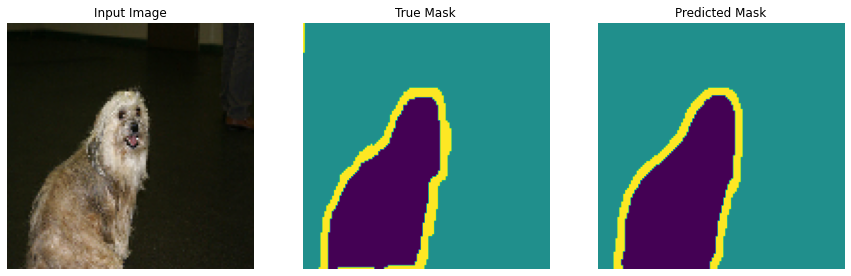

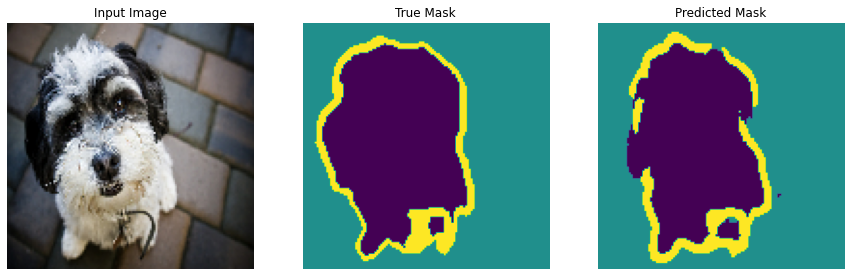

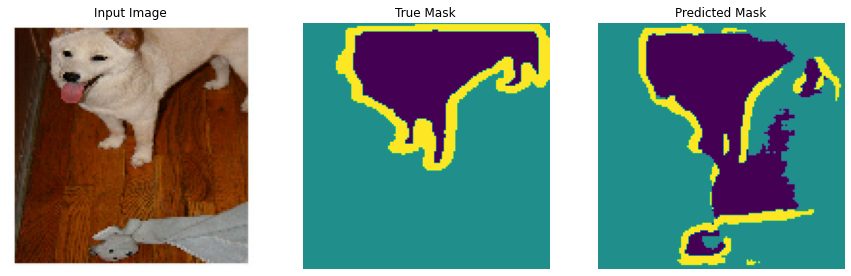

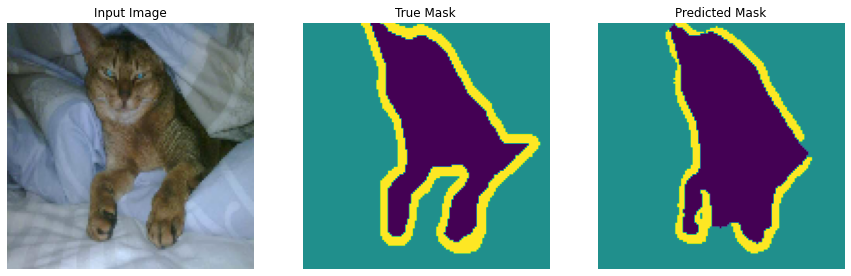

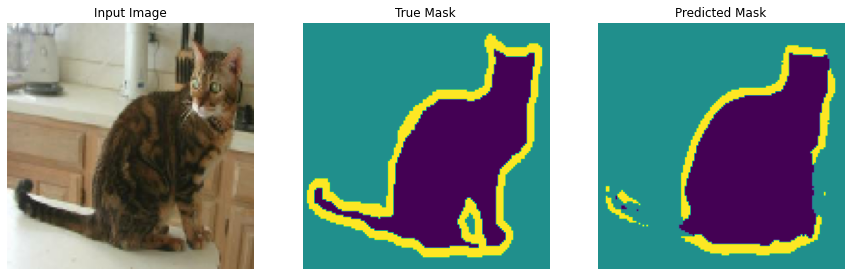

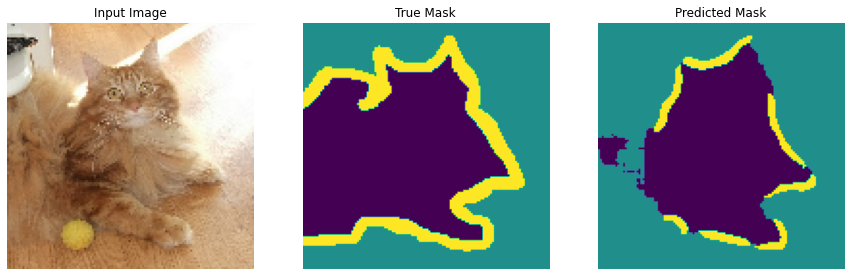

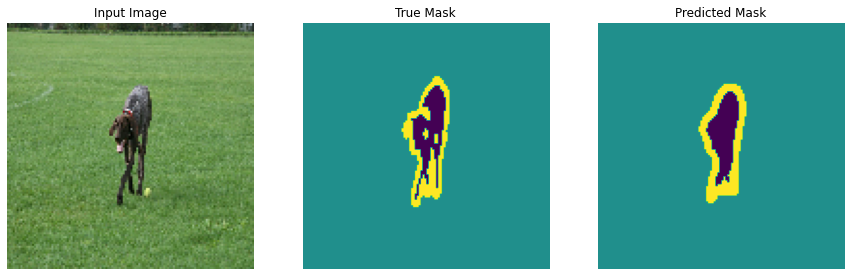

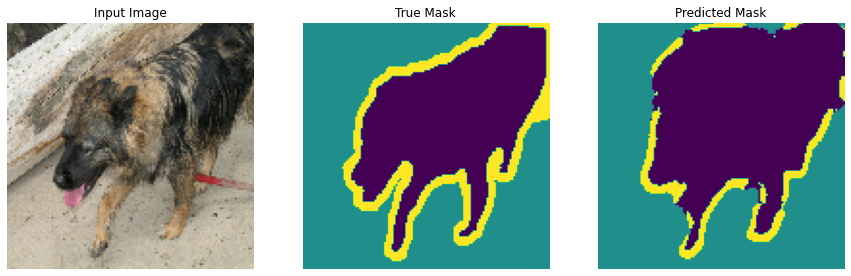

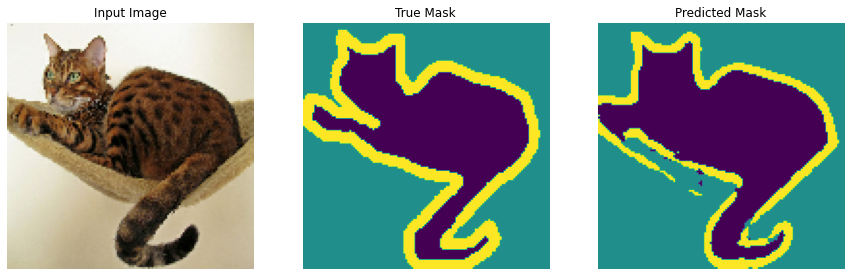

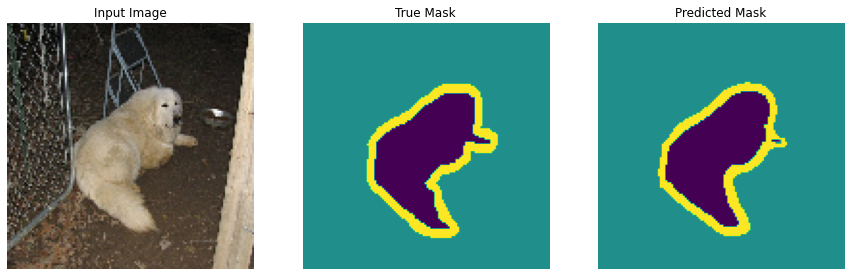

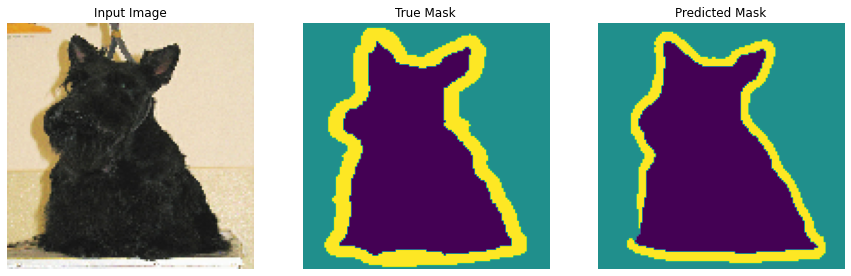

In [ ]:
def create_mask(pred_mask):
  pred_mask=tf.argmax(pred_mask,axis=-1)
  pred_mask=pred_mask[...,tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None,num=1):
  if dataset:
    for image,mask in dataset.take(num):
      pred_mask=unet_model.predict(image)
      display([image[0],mask[0],create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
            create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])


# For döngüsü resimlerin ve gerçek maskelerinin rastgele bir şekilde gelmesini sağlar. 
# Sonrasında show_predictions() fonksiyonuna göndererek eğitilen modelden oluşan predicted maske'yi döndürür.
for i in test_batches:
  random_index = np.random.choice(sample_batch[0].shape[0])
  sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
  show_predictions()





['cp-0000.ckpt.data-00000-of-00001', 'cp-0000.ckpt.index', 'checkpoint', 'cp-0006.ckpt.data-00000-of-00001', 'cp-0006.ckpt.index', 'cp-0012.ckpt.data-00000-of-00001', 'cp-0012.ckpt.index', 'cp-0017.ckpt.data-00000-of-00001', 'cp-0017.ckpt.index']
drive/MyDrive/training_2/cp-0017.ckpt
[0.9222935438156128, 0.7796787619590759, 0.64882493019104, 0.5807555913925171, 0.5349971652030945, 0.4928027391433716, 0.4484330117702484, 0.41745463013648987, 0.40374523401260376, 0.3807154893875122, 0.37047079205513, 0.34833091497421265, 0.3379928767681122, 0.3348434567451477, 0.32779279351234436, 0.3049360513687134, 0.30047285556793213, 0.2839862108230591, 0.2839009761810303, 0.2866594195365906]


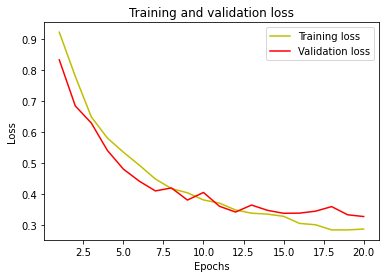

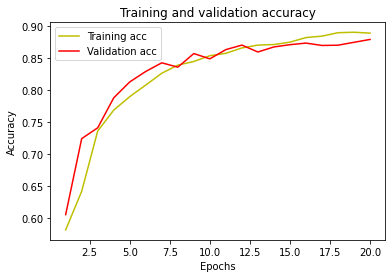

In [ ]:

loss = model_history .history['loss']
print(loss)

val_loss = model_history .history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = model_history .history['accuracy']
val_acc = model_history .history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()